In [2]:
#Import required tools from Shapely
from shapely import *
from shapely import geometry
from shapely.geometry import Point, Polygon, MultiPolygon
from shapely.ops import unary_union
import numpy as np

#Import required math tools
import scipy
import numpy as np
import geopandas as gpd
from scipy import stats
from scipy.stats import linregress
import time

#Imports required to write model data
import os
import csv
import pandas as pd

import geopandas as gpd
import time

In [4]:
#Define parameters
model_name = 'test'
total_time = 100
n = 5
c = 0.5
crit = 0.05 #stability criterion
size = 100
scale = 1
add_interval = 1 #interval for adding new depressions, in units of total_time

dt = crit / c
timesteps = total_time / dt

#Create empty data structures needed to run model
out = create_empty_data_lists()
all_depressions = initiate_model()

for tstep in range(int(timesteps)):
    
    try:
        #Add new depressions at interval
        if (tstep * dt) % add_interval == 0:
            new_depressions = add_new_depressions(n, size)
            all_depressions.extend(new_depressions)
            print('elapsed time = {}, adding new depressions'.format(tstep*dt))

            #Grow and merge depressions
        all_depressions = merge_depressions(grow_depressions(all_depressions.copy(), scale, c, dt))

        #Add all depression data to list of lists
        out = save_timestep(out, all_depressions, tstep, dt, n) 

        #Saves out list of lists to csv file each add_interval
        if len(all_depressions) <= 10:
            if tstep > (add_interval/dt)*n:
                df = pd.DataFrame(np.array(out).T, columns = ['tstep', 'N_t', 'N_m', 'area', 'perimeter'])
                df.to_csv(model_name + '.csv', index = False)

    except TypeError:
        break

elapsed time = 0.0, adding new depressions
create multipolygon geometry: 0.0048961639404296875
create buffer array: 0.08139967918395996
grow the shapes: 0.001107931137084961
create multipolygon geometry: 0.0001819133758544922
create buffer array: 0.23101520538330078
grow the shapes: 0.0010759830474853516
create multipolygon geometry: 0.0001888275146484375
create buffer array: 0.3911440372467041
grow the shapes: 0.0016398429870605469
create multipolygon geometry: 0.00018906593322753906
create buffer array: 0.6177442073822021
grow the shapes: 0.002148151397705078
create multipolygon geometry: 0.00018906593322753906
create buffer array: 0.70796799659729
grow the shapes: 0.0032219886779785156
create multipolygon geometry: 0.00021028518676757812
create buffer array: 1.0772700309753418
grow the shapes: 0.005011796951293945
create multipolygon geometry: 0.00021600723266601562
create buffer array: 1.9813508987426758
grow the shapes: 0.008452177047729492
create multipolygon geometry: 0.00029516

KeyboardInterrupt: 

In [12]:
x = MultiPolygon(all_depressions)
y = unary_union(all_depressions)
z = gpd.GeoSeries(all_depressions)

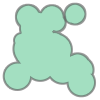

In [13]:
x

TypeError: 'int' object is not iterable

<AxesSubplot:>

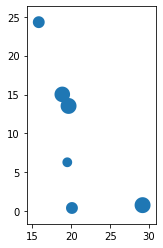

In [14]:
z.plot()

In [3]:
from shapely import geometry
from shapely.geometry import Point, Polygon
from shapely.ops import unary_union

#Import required math tools
import scipy
import numpy as np


#Imports required to write model data
def initiate_model():
    return []

"""ALL FUNCTIONS MUST BE TESTED BEFORE PLACING IN THIS FILE!"""

"""
---ADD NEW DEPRESSIONS TO MODEL SPACE---
Adds new depressions to the model space. New depression coordinates are selected
from a normal distribution with shape equal to the model space dimensions.

Inputs:
        number = the number of new depressions to add
        model_size = the linear dimension of the square model space
        
Returns:
        Function returns a list of Shapely polygons. Return must be 
        converted to MultiPolygons or GeoSeries to plot. 

Dependencies:
        This function does not depend on any other functions in this model.

"""

def add_new_depressions(number, model_size):
    #Choose coordinates of new depression centers from normal distribution
    coordinates = [(np.random.uniform(low = 0, high = model_size), 
                    np.random.uniform(low = 0, high = model_size)) for i in range(number)]
    #Give new depressions an area selected from a lognormal distribution
    init_buffer = np.sqrt(np.random.lognormal(mean = 0.1, sigma = 0.5, size = number) / np.pi)
    #Buffer points to create polygon depressions, add depressions to list.
    polygons = [Point(coordinates[j]).buffer(init_buffer[j]) for j in range(number)]
    return polygons

"""
---CALCULATE CHANGE IN DEPRESSION AREA---
This function calculates the difference in area between two shapes. It is used
within scale_to_buffer to find the correct buffer value to achieve the desired
change in depression area. 

Inputs:
        x = buffer values (float)
        shape = Shapely polygon object
        a_next = the desired area value

Returns:
        Function returns difference in areas between two Shapely polygons.

Dependencies:
        This function is used within scale_to_buffer.
"""
def a_diff(x, shape, a_next):
    return a_next - shape.buffer(x).area


"""
---CALCULATE BUFFER VALUE---
This function approximates the buffer needed for the solution to the 
differential equation:
    dA/dt = cA^k
    dA = cA^k dt
    A_next - A_last = c*(A_last)^k *dt
    A_next = A_last + c*(A_last)^k *dt
to find the buffer value that gives the next area value.

Inputs:
        shape = Shapely polygon object
        scale_factor = exponent "k" in differential equation
        c = constant of proportionality in differential equation
        dt = timestep length
        
        ***Keep c*dt small to avoid model instability!***

Returns: 
        Function returns buffer value to increase shape area such that it 
        satisfies the differential equation above. Minimization follows bisection
        method.

Dependencies:
        This function runs within the grow_depressions function.

c*dt needs to be small such that the dA is 'small' between timesteps
"""
def scale_to_buffer(shape, scale_factor, c, dt):
    a_next = c * dt * shape.area**scale_factor + shape.area
    return scipy.optimize.bisect(a_diff, -1., 10, args = (shape, a_next))



"""
Model flow:
    1. Add initial depressions to the model space.
    2. Grow depressions.
    3. Merge overlapping depressions.
    4. Add new depressions.
    5. Repeat Steps 2, 3, and 4
"""

"""
---Grow depressions---
This function solves the next timestep of the differential equation:
    dA/dt = cA^k
    dA = cA^k dt
    A_next - A_last = c*(A_last)^k *dt
    A_next = A_last + c*(A_last)^k *dt

Inputs:
        shapes = list of Shapely polygons/points
        scale_factor = scaling exponent "k" in the differential equation
        c = proportionality constant 
        dt = timestep length
        
        ***Keep c*dt small to avoid model instability!***
        
Returns:
        Function returns python list of polygons. Must be coverted to MultiPolygons
        or GeoSeries to plot. 
"""
def grow_depressions(shapes, scale_factor, c, dt):
    #Convert list of polygons to Shapely geometry MultiPolygons
    tic1 = time.time()
    polys = geometry.MultiPolygon(shapes)
    toc1 = time.time()
    print("create multipolygon geometry:", toc1-tic1)
    #Create an array of buffers for depression growth
    tic2 = time.time()
    bufferArray = np.array([scale_to_buffer(polys, scale_factor, c, dt) for i in range(len(polys))])
    toc2 = time.time()
    print("create buffer array:", toc2-tic2)
    #Increase depression areas using the buffer array
    tic3 = time.time()
    scaledShapes = [Polygon(polys[k]).buffer(bufferArray[k]) for k in range(len(polys))]
    toc3 = time.time()
    print("grow the shapes:", toc3-tic3)
    return scaledShapes

"""
---MERGE OVERLAPPING DEPRESSIONS---
This function uses Shapely's unary_union function to merge polygons. It does 
nothing new or unique outside of the unary_union. This function exists as a 
reminder of what the unary_union function is doing. 

Inputs:
        shapes = list of Shapely polygons
        
Returns:
        Function returns as Shapely MultiPolygons list. 
"""
def merge_depressions(shapes):
    if len(shapes) > 1:
        return list(unary_union(shapes))
    else:
        return shapes

"""
---SAVE TIMESTEP DATA---
This function records the timestep, total number of depressions added to the
model, total number of depressions (counting mergers), the areas, and the 
perimeters of each depression. 

Inputs:
        lists = Python list of lists, 
                rows represent ["t_step", "N_t", "N_m", "area", "perimeter"]
        shapes = Python list or Shapely MultiPolygons list
        tstep = timestep (iteration number)
        dt = timelegth of a single timestep 
        
Returns:
        Function returns updated list of lists. The lists are extended for 
        each successive timestep. 
        [[list of timesteps],
         [list of total number of depressions added to model space],
         [list of total number of depressions including mergers],
         [list of areas],
         [list of perimeters]]
"""
def save_timestep(lists, shapes, tstep, dt, n):
    areas = [s.area for s in shapes]
    perimeters = [s.length for s in shapes]
    N_t = int(np.floor((tstep) * dt)) * n + n
    N_m = len(areas)
    tstepList = [int(tstep) for i in range(len(areas))]
    N_t_list = [int(N_t) for i in range(len(areas))]
    N_m_list = [int(N_m) for i in range(len(areas))]
    lists[0].extend(tstepList)
    lists[1].extend(N_t_list)
    lists[2].extend(N_m_list)
    lists[3].extend(areas)
    lists[4].extend(perimeters)
    return lists

"""
---CREATE LIST OF LISTS TO SAVE DATA---
This function creates the list of lists for storing data from each timstep.

Inputs:
        None
Returns:
        This function returns an empty list of lists for use in the function
        save_timestep().
"""
def create_empty_data_lists():
    return [[], [], [], [], []]